In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date
import yfinance as yf


# Persiapan data close dan tanggal

In [2]:
df = pd.read_csv("KLBF_JK_Historical_fix.csv")
df = df[["Date",'Open','High','Low','Close']] #mengambil kolom Date dan Close

In [3]:
df["Date"] = pd.to_datetime(df["Date"]) # mengubah menjadi datetime

<Axes: title={'center': 'Klbf Stock Price'}, xlabel='Date'>

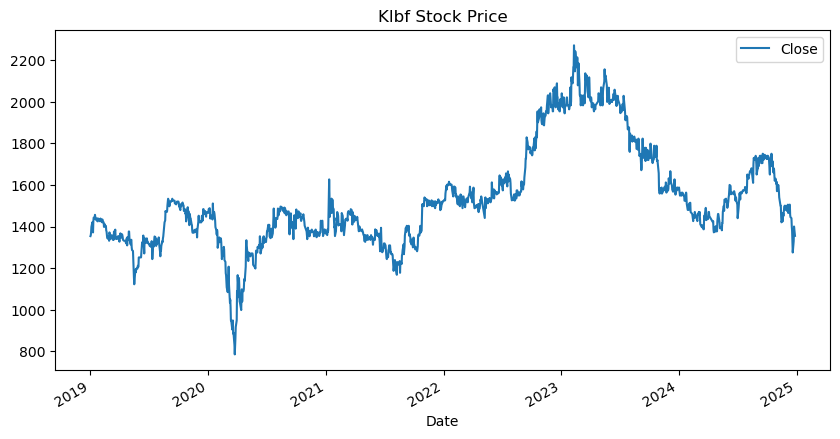

In [4]:
# visualisasi data
df.plot(x="Date", y="Close", title="Klbf Stock Price", figsize=(10,5))

In [5]:
# standariasasi data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_features = df[['Open','High','Low','Close']].copy()

# Membuat data lag untuk memprediksi harga saham besok

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features)
scaler_y = MinMaxScaler()
scaled_target = scaler_y.fit_transform(df[['Close']])

In [7]:
#export scaler
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))


In [8]:
pickle.dump(scaler_y, open('scaler_y.pkl', 'wb'))

In [9]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :])  # Fitur open, high, low
        y.append(data[i+time_steps, -1])    # Target close
    return np.array(X), np.array(y)

time_steps = 1
X, y = create_sequences(scaled_data, time_steps)
# y = scaler_y.inverse_transform(y.reshape(-1,1)).reshape(-1)

In [10]:
X.shape # (jumlah data, jumlah lag)

(1467, 1, 4)

# Train Test Split

In [11]:
# Split data 0.8 train, 0.2 test
split = int(0.8 * len(X)) #1150 data untuk training dan 288 data untuk testing

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [12]:
X_train.shape

(1173, 1, 4)

# Membuat model LSTM Adam

In [14]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop

In [15]:
n_features = 4                    

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    Dense(1)
])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

model.summary()

c:\Users\VICTUS\miniconda3\envs\breast-cancer\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,801 (456.25 KB)

 Trainable params: 116,801 (456.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2308 - root_mean_squared_error: 0.4793 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406 - root_mean_squared_error: 0.2014 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357 - root_mean_squared_error: 0.1888 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - root_mean_squared_error: 0.1861 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 6/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 7/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [17]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0826 
Test Loss: [0.00687588332220912, 0.08292094618082047]


In [18]:
predicted = model.predict(X_test)
# flatten predicted to array
y_pred_adam = scaler_y.inverse_transform(predicted.flatten().reshape(-1,1)).reshape(-1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [19]:
#save model
model.save('model_lstm_adam.h5')

## Training Model RMSProp

In [20]:
n_features = 4                    

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    Dense(1)
])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
model.compile(optimizer='rmsprop', loss='mse', metrics=[RootMeanSquaredError()])

model.summary()

c:\Users\VICTUS\miniconda3\envs\breast-cancer\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,801 (456.25 KB)

 Trainable params: 116,801 (456.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/1000


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2220 - root_mean_squared_error: 0.4698 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2575
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - root_mean_squared_error: 0.2264 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 6/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0720
Epoch 7/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.03

In [22]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0753 
Test Loss: [0.005900863092392683, 0.07681707292795181]


In [23]:
predicted = model.predict(X_test)
# flatten predicted to array
y_pred_rmsprop = scaler_y.inverse_transform(predicted.flatten().reshape(-1,1)).reshape(-1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [24]:
#save model
model.save('model_lstm_rmsprop.h5')

# evaluasi model

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

mse1 = mean_squared_error(y_test_inv, y_pred_adam)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(y_test_inv, y_pred_adam)
mape1 = np.mean(np.abs((y_test_inv - y_pred_adam) / y_test_inv)) * 100
r2_1 = r2_score(y_test_inv, y_pred_adam)

print("=== Model 1: LSTM optimasi Adam ===")
print("Mean Squared Error (MSE):", mse1)
print("Root Mean Squared Error (RMSE):", rmse1)
print("Mean Absolute Error (MAE):", mae1)
print("Mean Absolute Percentage Error (MAPE):", mape1)
print("R-squared:", r2_1)

mse1 = mean_squared_error(y_test_inv, y_pred_rmsprop)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(y_test_inv, y_pred_rmsprop)
mape1 = np.mean(np.abs((y_test_inv - y_pred_rmsprop) / y_test_inv)) * 100
r2_1 = r2_score(y_test_inv, y_pred_rmsprop)

print("=== Model 1: LSTM optimasi RMSProp ===")
print("Mean Squared Error (MSE):", mse1)
print("Root Mean Squared Error (RMSE):", rmse1)
print("Mean Absolute Error (MAE):", mae1)
print("Mean Absolute Percentage Error (MAPE):", mape1)
print("R-squared:", r2_1)

=== Model 1: LSTM optimasi Adam ===
Mean Squared Error (MSE): 15032.16471391552
Root Mean Squared Error (RMSE): 122.60572871573139
Mean Absolute Error (MAE): 99.42685580091414
Mean Absolute Percentage Error (MAPE): 6.175118802199028
R-squared: -0.25955236696790296
=== Model 1: LSTM optimasi RMSProp ===
Mean Squared Error (MSE): 12937.961627054683
Root Mean Squared Error (RMSE): 113.74516089511097
Mean Absolute Error (MAE): 93.15702892485122
Mean Absolute Percentage Error (MAPE): 5.853417109038642
R-squared: -0.08407807532943812


In [26]:
import tensorflow as tf
tf.__version__

'2.18.0'